# Bestmögliches Regressionsmodell - kaggle-Contest
Challenge: cml1/3Db Immobilienrechner  
Team: Alexander Shanmugam, Si Ben Tran, Gabriel Torrez Gamez, Haris Alic  
Aufgabe: 2.2 Bestmögliches Regressionsmodell - kaggle-Contest  

Entwickle mit beliebigen Algorithmen das bestmögliche Modell im Sinne des Mean absolute percentage error (MAPE). Vegleiche dabei mindestens drei algorithmische Ansätze, wobei ein multiples lineares Modell Teil davon sein soll als Benchmark. Untersuche die ‘Variable Importance’ für dein bestes Modell.

Abgabe

Notebook und daraus erstellter Bericht (ohne Code) als pdf, welche die Entwicklung deines besten Modells, sowie der zwei weiteren Modelle dokumentiert, inklusive verwendeter Features, Preprocessing, Model Selection Prozess und Untersuchung der ‘Variable Importance’.

Eingabe der Vorhersage des Preises für den Testdatensatz mit deinem bestmöglichen Modell auf kaggle.

---
# Module importieren
Hier in diesem Abschnitt importieren wir die wichtigisten Module, die wir für die weitere Bearbeitung unserer Machine Learning Modelle benötigen, um die Vorhersage des Immobilienpreises zu erstellen.

In [1]:
# Basic Data Science modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn modules

# pipeline
from sklearn.pipeline import make_pipeline

# KNNimputer
from sklearn.impute import KNNImputer

# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# linear_model
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

# neighbors
from sklearn.neighbors import KNeighborsRegressor

# tree
from sklearn.tree import DecisionTreeRegressor

# ensemble
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    HistGradientBoostingRegressor,
)

# model_selection
from sklearn.model_selection import train_test_split, GridSearchCV

# metrics
from sklearn.metrics import mean_absolute_percentage_error

# xgboost
from xgboost import XGBRegressor


---
# Daten importieren
Hier in diesem Abschnitt importieren wir die Immobilien Daten, die uns Fernando zur Verfügung gestellt hat.  
raw_data ist der vollständige Datensatz der Kompetition  
raw_data_kaggle ist der Datensatz der Kompetition


In [2]:
# url and relative path for the data

rel_path = "https://raw.githubusercontent.com/Immobilienrechner-Challenge/data/main/clean_gde_v2.csv"
# Clean data einlesen
rel_path_kaggle = "https://github.com/Immobilienrechner-Challenge/data/blob/main/kaggle_gde_cleaned.parquet?raw=true"

# Read data into pandas dataframe
raw_data = pd.read_csv(rel_path, low_memory=False)
raw_data_kaggle = pd.read_parquet(rel_path_kaggle)


---
# Daten vorbereiten
Hier werden die Daten vorbereitet, indem wir die Daten in Trainings- und Validierungsdaten aufteilen.  

In [3]:
# drop the columns municipality, street, street_nr and zip_code
data = raw_data.drop(
    columns=[
        "municipality",
        "street",
        "street_nr",
        "zip_code",
        "availability",
        "features",
    ]
)

# drop rows where price is nan
data = data.dropna(subset=["price"])

# count number of dtypes
print("Number of dtypes:\n", data.dtypes.value_counts())

# print dtypes object columns
print("Dtypes object columns:", data.select_dtypes(include="object").columns)

# make one hot encoding for the columns objects
data = pd.get_dummies(data, columns=["canton", "type"])

# print shape of df
print("Shape of df:", data.shape)

# get top 10 cols with highest NA values
print(
    "Top 10 cols with highest NA values:",
    data.isna().sum().sort_values(ascending=False).head(30),
)


Number of dtypes:
 float64    56
object      2
dtype: int64
Dtypes object columns: Index(['canton', 'type'], dtype='object')
Shape of df: (21412, 103)
Top 10 cols with highest NA values: last_refurbishment     19165
floor                  16076
floor_space            15883
year_built             14496
plot_area              13721
gde_politics_pda       10268
gde_politics_bdp        8472
gde_politics_rights     6447
gde_politics_glp        5676
gde_politics_evp        3996
living_space            1295
rooms                    677
gde_politics_gps         444
gde_politics_cvp         302
gde_politics_fdp         131
gde_politics_sp           82
gde_politics_svp          49
canton_OW                  0
canton_NW                  0
canton_SH                  0
canton_SO                  0
canton_SZ                  0
canton_NE                  0
canton_LU                  0
canton_JU                  0
canton_GR                  0
canton_GL                  0
canton_GE                  0
c

Hier sind die Kaggle Test Daten. Die Prediction dieser Daten müssen wir einreichen.


In [4]:
# drop the columns municipality, street, street_nr and zip_code
data_kaggle = raw_data_kaggle.drop(
    columns=[
        "municipality",
        "street",
        "street_nr",
        "zip_code",
        "availability",
        "features",
    ]
)

# set index column to index
data_kaggle.set_index("Index", inplace=True, drop=True)

# count number of dtypes
print("Number of dtypes:\n", data_kaggle.dtypes.value_counts())

# print dtypes object columns
print("Dtypes object columns:", data_kaggle.select_dtypes(include="object").columns)

# make one hot encoding for the columns objects
data_kaggle = pd.get_dummies(data_kaggle, columns=["canton", "type"])

# print shape of df
print("Shape of df_kaggle:", data_kaggle.shape)

# get top 10 cols with highest NA values
print(
    "Top 10 cols with highest NA values:",
    data_kaggle.isna().sum().sort_values(ascending=False).head(30),
)


Number of dtypes:
 float64    55
object      2
dtype: int64
Dtypes object columns: Index(['canton', 'type'], dtype='object')
Shape of df_kaggle: (24556, 103)
Top 10 cols with highest NA values: last_refurbishment     21632
floor_space            19501
floor                  19173
year_built             15291
plot_area              15072
gde_politics_pda       12031
gde_politics_bdp        8751
gde_politics_evp        7469
gde_politics_rights     4667
gde_politics_glp        3386
living_space            1814
gde_politics_gps        1150
rooms                    999
gde_politics_cvp         636
gde_politics_fdp         382
gde_politics_sp          224
gde_politics_svp         158
canton_OW                  0
canton_NW                  0
canton_SH                  0
canton_SO                  0
canton_SZ                  0
canton_NE                  0
canton_LU                  0
canton_JU                  0
canton_GR                  0
canton_GL                  0
canton_GE              

## Daten reparieren


In [5]:
# modify matrix data_kaggle to have the same columns
diff_cols = list(set(data.columns) - set(data_kaggle.columns) - {"price"})
data_kaggle[diff_cols] = 0

# modify matrix data to have the same columns
diff_cols2 = list(set(data_kaggle.columns) - set(data.columns))
data[diff_cols2] = 0


## Daten splitten


In [6]:
# splitting dataframe into train and test set
train, val = train_test_split(data, test_size=0.2, random_state=42)

# splitting train and val into X and y
X_train = train.drop("price", axis=1)
y_train = train["price"]

X_val = val.drop("price", axis=1)
y_val = val["price"]

# creating a split with full data
X = data.drop("price", axis=1)
y = data["price"]

# print shapes
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_val: ", X_val.shape)
print("Shape of y_val: ", y_val.shape)
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)


Shape of X_train:  (17129, 103)
Shape of y_train:  (17129,)
Shape of X_val:  (4283, 103)
Shape of y_val:  (4283,)
Shape of X:  (21412, 103)
Shape of y:  (21412,)


### Vergleich Kaggle

Hier zeigen wir zum Vergleich die Dimensionen des Kaggle Datensatz


In [7]:
# print shape of X
print("Shape of data_kaggle: ", data_kaggle.shape)


Shape of data_kaggle:  (24556, 103)


## Datenimputation


In [8]:
cols = X_train.columns

X_train_with_na = X_train.copy()
X_train = pd.DataFrame(
    KNNImputer(n_neighbors=5).fit_transform(X_train[cols]), columns=X_train.columns
)
print("X_train transformed")

X_val_with_na = X_val.copy()
X_val = pd.DataFrame(
    KNNImputer(n_neighbors=5).fit_transform(X_val[cols]), columns=X_val.columns
)
print("X_val transformed")

X_kaggle_with_na = data_kaggle.copy()
data_kaggle = pd.DataFrame(
    KNNImputer(n_neighbors=5).fit_transform(data_kaggle[cols]),
    columns=data_kaggle.columns,
    index=data_kaggle.index,
)
print("data_kaggle transformed")


X_train transformed
X_val transformed
data_kaggle transformed


## Daten standardisieren


In [9]:
cols = X_train.columns
scaler = StandardScaler().fit(X_train[cols])
scaler_na = StandardScaler().fit(X_train_with_na[cols])

X_train = pd.DataFrame(scaler.transform(X_train[cols]), columns=cols)
X_val = pd.DataFrame(scaler.transform(X_val[cols]), columns=cols)
X_kaggle = pd.DataFrame(
    scaler.transform(data_kaggle[cols]), columns=cols, index=data_kaggle.index
)

X_train_with_na = pd.DataFrame(
    scaler_na.transform(X_train_with_na[cols]), columns=cols)
X_val_with_na = pd.DataFrame(
    scaler_na.transform(X_val_with_na[cols]), columns=cols)
X_kaggle_with_na = pd.DataFrame(
    scaler_na.transform(X_kaggle_with_na[cols]), columns=cols, index=data_kaggle.index
)


---
# Modell 1 - Multiple Lineare Model
Modell 1 ist ein multiples lineares Modell, welches wir als Benchmark für die weiteren Modelle verwenden werden. Wir haben uns für dieses Modell entschieden, da es ein einfaches Modell ist, welches wir schnell erstellen können und es uns ermöglicht, die Vorhersage des Preises zu erstellen.
Das Multiple Lineare Regression ist ein statistisches Modell, das verwendet wird, um die Beziehung zwischen einer abhängigen und einer oder mehreren unabhängigen Variablen zu beschreiben. Es geht davon aus, dass die Beziehung zwischen den Variablen linear ist und dass die Zufallsfehler normalverteilt sind.

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params: {'fit_intercept': False, 'positive': True}
Mean absolute percentage error: 1.7964395444929788


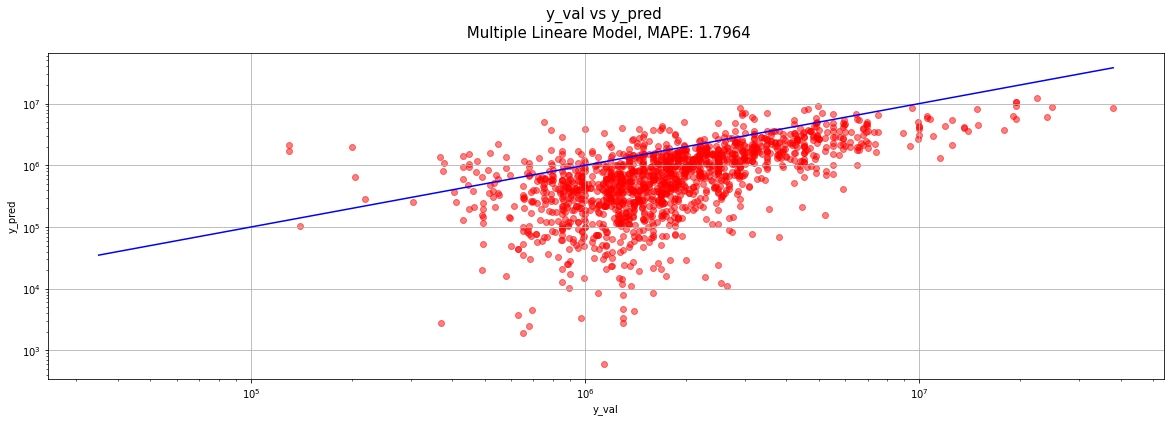

In [10]:
# make a linear regression function with gridsearchcv
def linear_regression(X_train, y_train, X_val, y_val, cv=5, verbose=1):
    """
    Function to make a linear regression model with gridsearchcv.

    Parameters
    ----------
    X_train : array-like
        Training data.
    y_train : array-like
        Target values.
    X_val : array-like
        Test data.
    y_val : array-like
        Target values.
    cv : int, default=5
        Cross-validation fold.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.

    Returns
    -------
    model : object
        the best linear regression fitted model
    """

    # create a linear regression model
    lin_reg = LinearRegression()

    # create a dictionary with the parameters
    params = {
        "fit_intercept": [True, False],
        "positive": [True, False],
    }

    # create a gridsearchcv model
    lin_reg_grid = GridSearchCV(
        lin_reg,
        params,
        cv=cv,
        n_jobs=8,
        scoring="neg_mean_absolute_percentage_error",
        verbose=verbose,
    )

    # fit the model
    lin_reg_grid.fit(X_train, y_train)

    # print the best parameters
    print("Best params:", lin_reg_grid.best_params_)

    # make predictions
    y_pred_lin = lin_reg_grid.predict(X_val)

    # print the mean absolute percentage error
    mape_lin_reg = mean_absolute_percentage_error(y_val, y_pred_lin)
    print("Mean absolute percentage error:", mape_lin_reg)

    # create y_val and y_pred plot
    plt.figure(figsize=(20, 6))
    plt.scatter(y_val, y_pred_lin, c="red", alpha=0.5)
    plot_lin = np.linspace(np.min(y_val), np.max(y_val), 2)
    plt.plot(plot_lin, plot_lin, c="blue")
    plt.grid()
    plt.xlabel("y_val")
    plt.ylabel("y_pred")
    plt.title(
        "y_val vs y_pred \n Multiple Lineare Model, MAPE: "
        + str(np.round(mape_lin_reg, 4)),
        fontsize=15,
        y=1.03,
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return lin_reg_grid


# call function linear_regression for dev data
linear_regression = linear_regression(
    X_train, y_train, X_val, y_val, cv=5, verbose=1)
    

Wir evaluieren alle unsere Modelle mit dem MAPE Score und zeigen mittels einer Visualisierung wie gut unser Modell den Haus Preis vorhersagen kann.  
In der Visualisierung wird der richtige Preis durch die x-Achse dargestellt. Die blaue Linie repraesentiert ein perfektes Modell. 
Sprich, wenn ein roter Punkt sich auf der blauen Linie befindet, so ist der vorhergesagener Wert identisch, wie die des richtigen Wertes. Dies weare der Idealfall. 

Man erkennt in unserem Plot, dass das multiple Lineare Regressionsmodell die Werte der Preise eher unterschätzt, da die roten Punkte sich unterhalb der blauen Linie sich befinden. Auch erkennen wir vereinzelte Punkte, die sehr weit entfernt von der blauen Linien sind. Aus diesem Grund ist es auch nicht verwunderlich, dass unser MAPE Score einen sehr hohen Wert verzeichnet. 

---
# Modell 2 - Lasso Regression
Modell 2 ist ein multiples lineares Lasso Modell. Die Lasso Regression ist eine Art von Regression, die eine Regularisierungstechnik namens L1-Regularisierung verwendet. Diese Technik fügt dem konventionellen Fehlerterm einen Penalties-Term hinzu, der die Summe der absoluten Werte der Regressionskoeffizienten minimiert. Lasso Regression kann verwendet werden, um automatisch unbedeutende Variablen auszuschließen und die Modellkomplexität zu reduzieren.

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
Best parameters: {'alpha': 100000.0, 'fit_intercept': True, 'max_iter': 100, 'positive': False, 'random_state': 42, 'selection': 'cyclic'}
Mean absolute percentage error: 0.5056864731722799


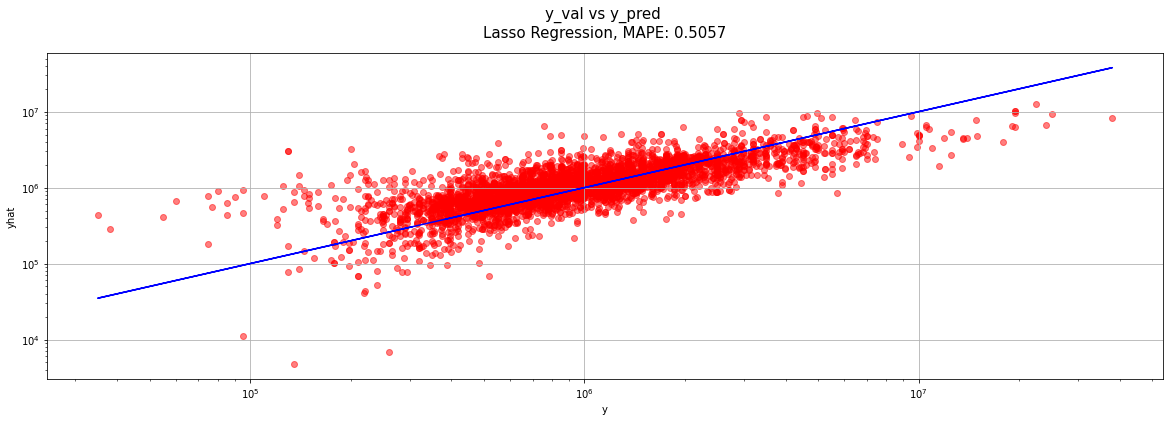

In [15]:
# make a lasso regression function with gridsearchCV
def lasso_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    alphas=[0.001, 1],
    iterations=[1000],
    cv=5,
    verbose=1,
):
    """
    This function makes a lasso regression with gridsearchCV

    Parameters
    ----------
    X_train : numpy array
        X_train data.
    y_train : numpy array
        y_train data.
    X_val : numpy array
        X_val data.
    y_val : numpy array
        y_val data.
    alphas : numpy array
        alphas for the lasso regression.
    iterations : numpy array
        iterations for the lasso regression.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.

    Returns
    -------
    model : object
        the best lasso regression fitted model
    """

    # create Lasso Modell with gridsearch cv
    lasso = Lasso()

    # create parameter grid
    param_grid = {
        "alpha": alphas,
        "fit_intercept": [True, False],
        "max_iter": iterations,
        "random_state": [42],
        "positive": [True, False],
        "selection": ["random", "cyclic"],
    }

    # create gridsearchcv model
    lasso_grid = GridSearchCV(
        lasso,
        param_grid,
        cv=cv,
        n_jobs=8,
        scoring="neg_mean_absolute_percentage_error",
        verbose=verbose,
    )

    # fit the model
    lasso_grid.fit(X_train, y_train)

    # print the best parameters
    print("Best parameters:", lasso_grid.best_params_)

    # predict the model
    y_pred_lasso = lasso_grid.predict(X_val)

    # print the mean absolute percentage error
    mape_lasso = mean_absolute_percentage_error(y_val, y_pred_lasso)
    print("Mean absolute percentage error:", mape_lasso)

    # create plot y vs yhat an draw model line
    plt.figure(figsize=(20, 6))
    plt.scatter(y_val, y_pred_lasso, c="red", alpha=0.5)
    plt.plot(y_val, y_val, c="blue")
    plt.grid()
    plt.xlabel("y")
    plt.ylabel("yhat")
    plt.title(
        "y_val vs y_pred \nLasso Regression, MAPE: " +
        str(np.round(mape_lasso, 4)),
        fontsize=15,
        y=1.03,
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return lasso_grid


# call the function
lasso_regression = lasso_regression_gridsearchCV(
    X_train, y_train, X_val, y_val, np.logspace(5, 7, 100), [100], cv=5, verbose=1
)


Wir erkennen im Plot eine deutliche Verbesserung mittels Lasso Regression, verglichen zum mulitplen Linearen modell. Auch die MAPE Metrik ist deutlich gesunken auf 0.5. Da bei der Lasso Regression Features bestraft werden, die keinen Beitrag zur vorhersage des Haus Preises haben, können wir hier uns schon die ersten wichtigen Features herausextrahieren. Sprich Features die keinen Koeffizienten Wert von 0 afuweisen in unserem Modell. 

## Untersuchung der Variable Importance Modell 2

Features with coef != 0: Index(['RiversAndLakesL', 'floor_space', 'gde_area_forest_percentage',
       'gde_area_settlement_percentage', 'gde_foreigners_percentage',
       'gde_politics_evp', 'gde_politics_fdp', 'living_space', 'canton_GE',
       'canton_VD'],
      dtype='object')


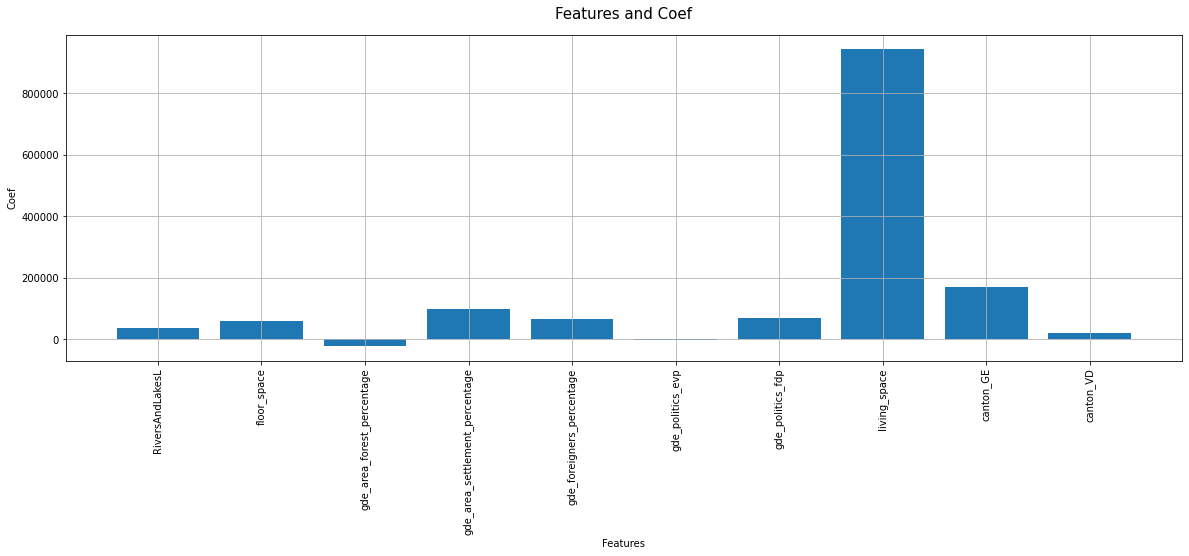

In [16]:
# get all features with coef > 0
lasso_features = X_train.columns[lasso_regression.best_estimator_.coef_ != 0]

# print the features
print("Features with coef != 0:", lasso_features)

# barplot of the features and coefs
plt.figure(figsize=(20, 6))
plt.bar(
    lasso_features,
    lasso_regression.best_estimator_.coef_[
        lasso_regression.best_estimator_.coef_ != 0],
)
plt.xticks(rotation=90)
plt.grid()
plt.xlabel("Features")
plt.ylabel("Coef")
plt.title("Features and Coef", fontsize=15, y=1.03)
plt.show()


Hier in diesem Barplot werden die Features gegenüber deren Koeffizienten Wert visualisiert. Wir erkennen deutlich, das living_space den grössten Koeffizienten hat und somit einen wesentlich Beitrag zu unserem Lasso Modell beiträgt. Wir können nun unser Modell vereinfachen, indem wir nur die Features auswählen und die Lasso Regression nochmals durchführen. 

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best parameters: {'alpha': 100000.0, 'fit_intercept': True, 'max_iter': 100, 'positive': True, 'random_state': 42, 'selection': 'cyclic'}
Mean absolute percentage error: 0.5084034294411344


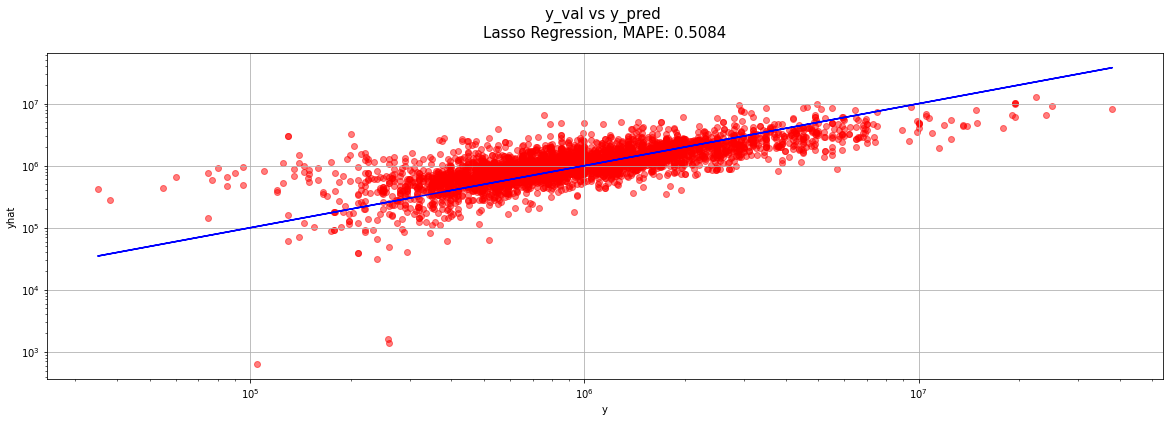

In [13]:
# call the function
lasso_regression_reduced = lasso_regression_gridsearchCV(
    X_train[lasso_features],
    y_train,
    X_val[lasso_features],
    y_val,
    np.logspace(5, 6, 10),
    [100],
    cv=5,
    verbose=1,
)


Wie zu erwarten hat sich der MAPE Wert sehr leicht verschlechtert, jedoch ist diese im Hunderstel Bereich und somit in Ordnung, da wir nun unser Modell mit viel weniger Features beschreiben können als davor mit dem ganzen Datensatz.

---
# Modell 3 - Ridge Regression
Modell 3 ist ein multiples lineares Ridge Modell. Die Ridge Regression ist eine weitere Art von Regression, die eine Regularisierungstechnik namens L2-Regularisierung verwendet. Diese Technik fügt dem konventionellen Fehlerterm einen Penalties-Term hinzu, der die Summe der Quadrate der Regressionskoeffizienten minimiert. Ridge Regression kann verwendet werden, um Probleme der Überanpassung (overfitting) zu vermeiden und die Robustheit des Modells zu verbessern.

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Best parameters: {'alpha': 10000.0, 'fit_intercept': True, 'max_iter': 100, 'positive': False, 'random_state': 42}
Mean absolute percentage error: 0.5004054411589232


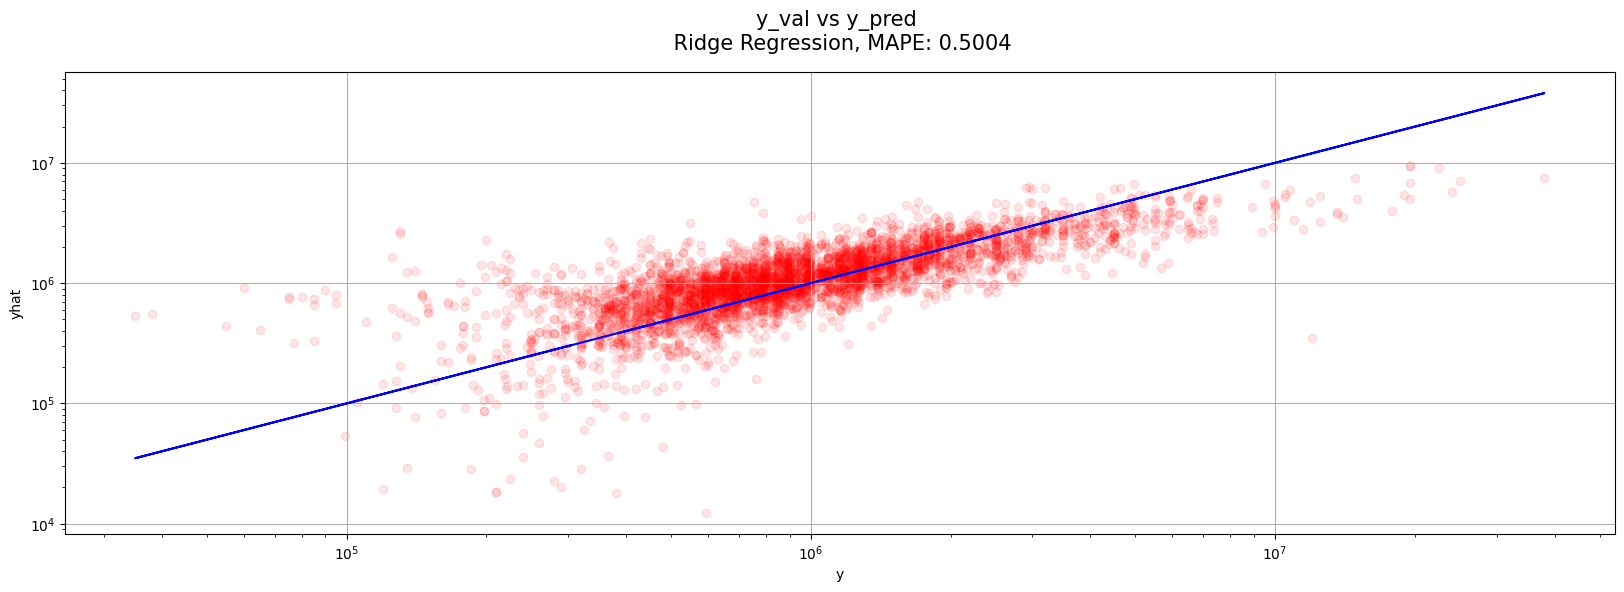

In [14]:
# make a ridge regression function with gridsearchCV
def ridge_regression_gridsearchCV(
    X_train, y_train, X_val, y_val, alphas=[1], iterations=[1000], cv=5, verbose=1
):
    """
    This function makes a ridge regression with gridsearchCV

    Parameters
    ----------
    X_train : numpy array
        X_train data.
    y_train : numpy array
        y_train data.
    X_val : numpy array
        X_val data.
    y_val : numpy array
        y_val data.
    alphas : numpy array
        alphas for the ridge regression.
    iterations : numpy array
        iterations for the ridge regression.
    cv : int, default=5
        Cross-validation fold.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.


    Returns
    -------
    model : object
        the best ridge regression fitted model
    """

    # create Ridge Modell with gridsearch cv
    ridge = Ridge()

    # create parameter grid
    param_grid = {
        "alpha": alphas,
        "fit_intercept": [True, False],
        "max_iter": iterations,
        "positive": [True, False],
        "random_state": [42],
    }

    # create gridsearchcv model
    ridge_grid = GridSearchCV(
        ridge,
        param_grid,
        cv=cv,
        n_jobs=8,
        scoring="neg_mean_absolute_percentage_error",
        verbose=verbose,
    )

    # fit the model
    ridge_grid.fit(X_train, y_train)

    # print the best parameters
    print("Best parameters:", ridge_grid.best_params_)

    # predict the model
    y_pred_ridge = ridge_grid.predict(X_val)

    # print the mean absolute percentage error
    mape_ridge = mean_absolute_percentage_error(y_val, y_pred_ridge)
    print("Mean absolute percentage error:", mape_ridge)

    # create plot y vs yhat an draw model line
    plt.figure(figsize=(20, 6))
    plt.scatter(y_val, y_pred_ridge, c="red", alpha=0.5)
    plt.plot(y_val, y_val, color="b")
    plt.grid()
    plt.xlabel("y")
    plt.ylabel("yhat")
    plt.title(
        "y_val vs y_pred \n Ridge Regression, MAPE: " +
        str(np.round(mape_ridge, 4)),
        fontsize=15,
        y=1.03,
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return ridge_grid


# call the function
ridge_regression = ridge_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    np.logspace(4, 6, 100),
    iterations=[100],
    cv=5,
    verbose=1,
)


Wir schauen uns nun das Ridge Regression Modell an uns erkennen, das auch hier die roten Punkte sich deutlich besser auf der blauen Linie liegen als beim multiplen Linearen Modell. Entsprechend ist auch der MAPE deutlich tiefer. Sowohl beim Lasso als auch bei der Ridge Regression können wir sagen, das sich der MAPE Score ähnlich sind und gleich gute Resultate liefert. Da ein MAPE von ca. 50% uns nicht genügt, verwenden wir weitere Modelle, um unsere vorhersage über den Immobilienpreis zu verbessern.

---
# Modell 4 - Elastic Net Regression
Modell 4 ist ein multiples lineares Elastic Net Modell. Das Elastic Net Regression ist eine Kombination aus Lasso- und Ridge-Regression. Es vereint die Vorteile beider Methoden, indem es eine Kombination der L1- und L2-Regularisierung verwendet. Dies ermöglicht es, unbedeutende Variablen auszuschließen und gleichzeitig die Modellkomplexität zu begrenzen.

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best parameters: {'alpha': 100000.0, 'fit_intercept': True, 'l1_ratio': 1, 'max_iter': 100, 'positive': False, 'random_state': 42, 'selection': 'cyclic'}


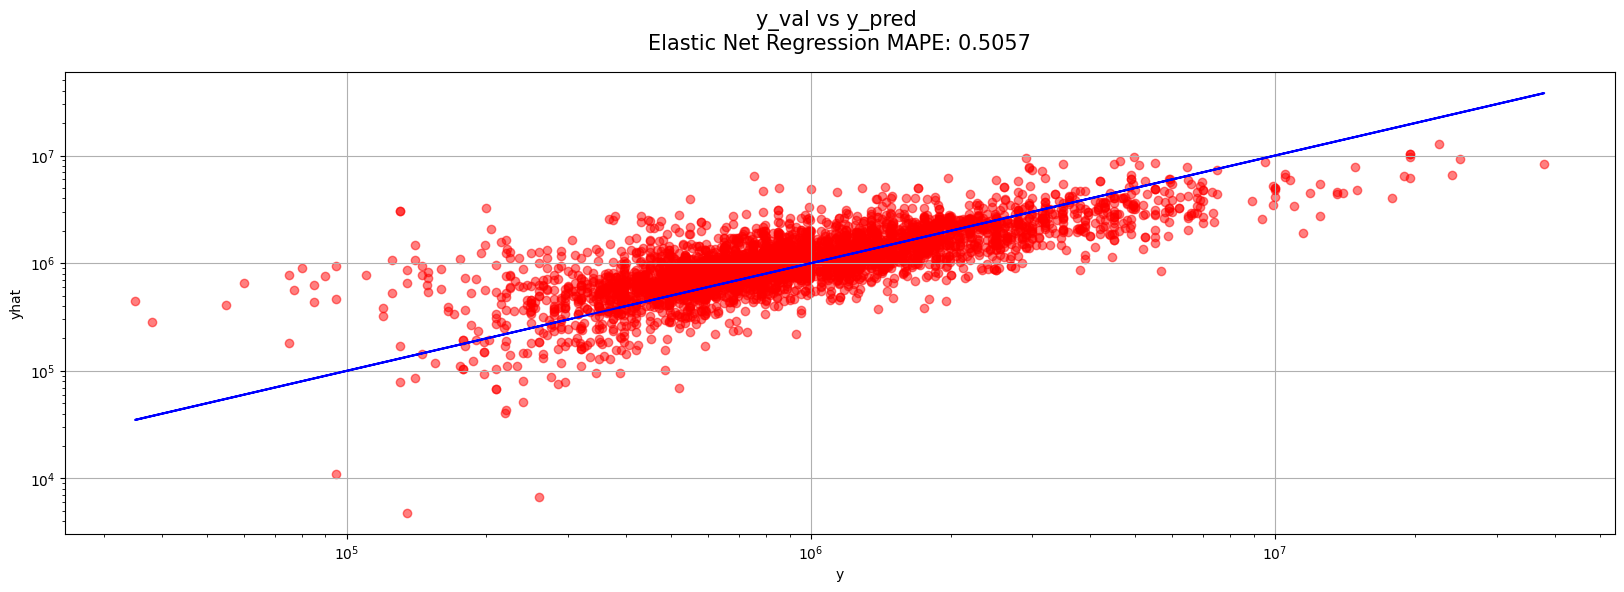

In [15]:
# make a elastic net regression function with gridsearchCV
def elastic_net_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    alphas=[1],
    l1_ratio=[0.5],
    iterations=[1000],
    cv=5,
    verbose=1,
):
    """
    This function makes a elastic net regression with gridsearchCV

    Parameters
    ----------
    X_train : numpy array
        X_train data.
    y_train : numpy array
        y_train data.
    X_val : numpy array
        X_val data.
    y_val : numpy array
        y_val data.
    alphas : numpy array
        alphas for the elastic net regression.
    l1_ratio : numpy array
        l1_ratio for the elastic net regression.
    iterations : numpy array
        iterations for the elastic net regression.
    cv : int, default=5
        Cross-validation fold.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.

    Returns
    -------
    model : object
        the best elastic net regression fitted model
    """

    # create Elastic Net Modell with gridsearch cv
    elastic_net = ElasticNet()

    # create parameter grid
    param_grid = {
        "alpha": alphas,
        "fit_intercept": [True, False],
        "l1_ratio": l1_ratio,
        "max_iter": iterations,
        "positive": [True, False],
        "random_state": [42],
        "selection": ["random", "cyclic"],
    }

    # create gridsearchcv model
    elastic_net_grid = GridSearchCV(
        elastic_net,
        param_grid,
        cv=cv,
        n_jobs=8,
        scoring="neg_mean_absolute_percentage_error",
        verbose=verbose,
    )

    # fit the model
    elastic_net_grid.fit(X_train, y_train)

    # print the best parameters
    print("Best parameters:", elastic_net_grid.best_params_)

    # predict the model
    y_pred_elastic_net = elastic_net_grid.predict(X_val)

    # print the mean absolute percentage error
    mape_elastic_net = mean_absolute_percentage_error(
        y_val, y_pred_elastic_net)

    # create plot y vs yhat an draw model line
    plt.figure(figsize=(20, 6))
    plt.scatter(y_val, y_pred_elastic_net, c="red", alpha=0.5)
    plt.plot(y_val, y_val, color="b")
    plt.grid()
    plt.xlabel("y")
    plt.ylabel("yhat")
    plt.title(
        "y_val vs y_pred \nElastic Net Regression MAPE: "
        + str(np.round(mape_elastic_net, 4)),
        fontsize=15,
        y=1.03,
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return elastic_net_grid


# call the function
elastic_net_regression = elastic_net_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    alphas=np.logspace(5, 6, 30),
    l1_ratio=[1],
    iterations=[100],
    cv=5,
    verbose=1,
)


Bei der Elastic Net Regression erkennen wir keinen weitere Verbesserung des MAPE Scores. Wir testen nun weitere Modelle in unserem Datensatz aus.

---
# Modell 5 - KNN Regression
Modell 5 ist ein KNN Modell. Die KNN Regression (K-Nearest Neighbors Regression) ist ein nicht-parametrisches Modell, das verwendet wird, um Vorhersagen auf der Grundlage von Beobachtungen in den nächsten Nachbarschaft vorzunehmen. Es geht davon aus, dass Beobachtungen, die in der Vergangenheit ähnlich waren, auch in der Zukunft ähnlich sein werden.

Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best parameters: {'algorithm': 'ball_tree', 'leaf_size': 5, 'metric': 'minkowski', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


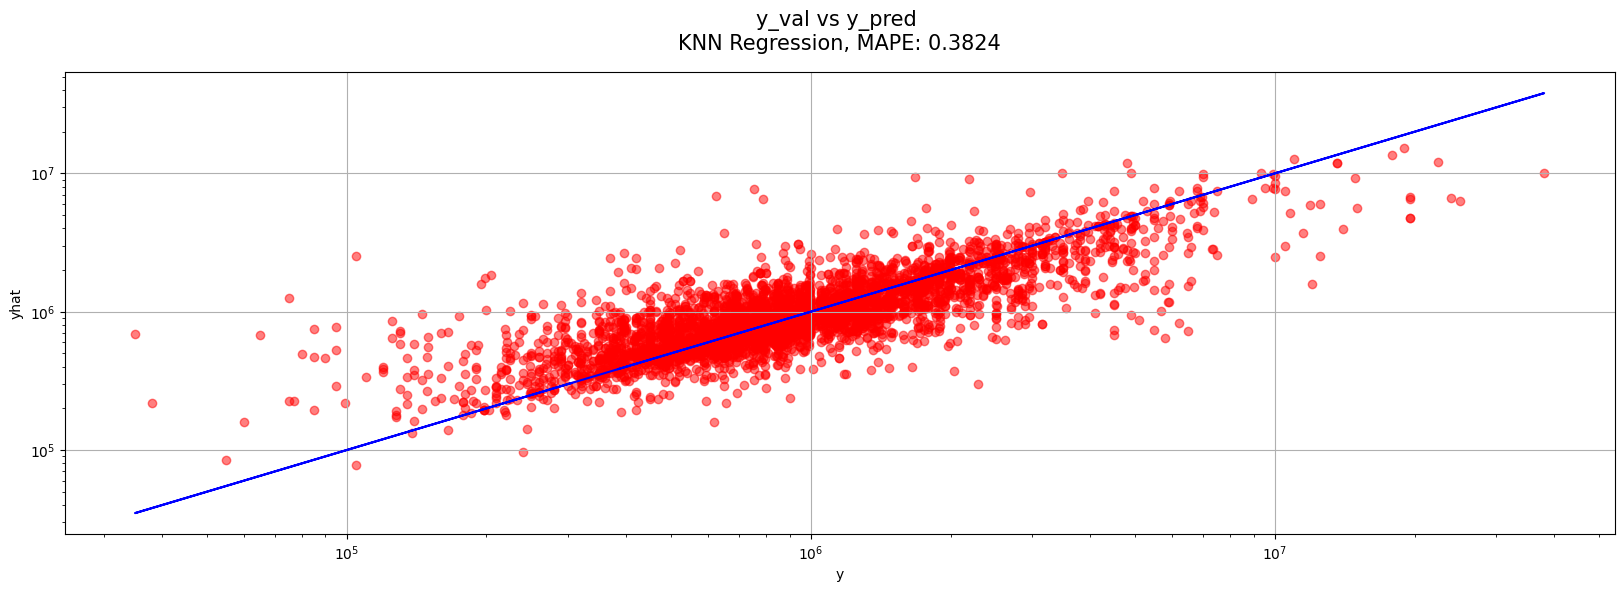

In [16]:
# make a KNN regression function with gridsearchCV
def knn_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    n_neighbors=[5],
    power=[1, 2],
    leaf_size=[30],
    cv=5,
    verbose=1,
):
    """
    This function makes a KNN regression with gridsearchCV

    Parameters
    ----------
    X_train : numpy array
        X_train data.
    y_train : numpy array
        y_train data.
    X_val : numpy array
        X_val data.
    y_val : numpy array
        y_val data.
    n_neighbors : numpy array
        n_neighbors for the KNN regression.
    power : numpy array
        power for the KNN regression.
    leaf_size : numpy array
        leaf_size for the KNN regression.
    cv : int, default=5
        Cross-validation fold.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.

    Returns
    -------
    model : object
        the best KNN regression fitted model
    """
    # create KNN Modell with gridsearch cv
    knn = KNeighborsRegressor()

    # create parameter grid
    param_grid = {
        "n_neighbors": n_neighbors,
        "weights": ["uniform", "distance"],
        "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
        "leaf_size": leaf_size,
        "p": power,
        "metric": ["minkowski"],
    }

    # create gridsearchcv model
    knn_grid = GridSearchCV(
        knn,
        param_grid,
        cv=cv,
        n_jobs=8,
        scoring="neg_mean_absolute_percentage_error",
        verbose=verbose,
    )

    # fit the model
    knn_grid.fit(X_train, y_train)

    # print the best parameters
    print("Best parameters:", knn_grid.best_params_)

    # predict the model
    y_pred_knn = knn_grid.predict(X_val)

    # print the mean absolute percentage error
    mape_knn = mean_absolute_percentage_error(y_val, y_pred_knn)

    # create plot y vs yhat an draw model line
    plt.figure(figsize=(20, 6))
    plt.scatter(y_val, y_pred_knn, c="red", alpha=0.5)
    plt.plot(y_val, y_val, color="b")
    plt.grid()
    plt.xlabel("y")
    plt.ylabel("yhat")
    plt.title(
        "y_val vs y_pred \nKNN Regression, MAPE: " +
        str(np.round(mape_knn, 4)),
        fontsize=15,
        y=1.03,
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return knn_grid


# call the function
knn_regression = knn_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    n_neighbors=[3],
    leaf_size=[5],
    power=[1],
    cv=4,
    verbose=1,
)


Es ist sehr interessant zu sehen, dass die KNN Regression eine deutliche Verbesserung zur vorhersage des Immobilienpreises beitraegt. Der MAPE ist deutlich gesunken und befindet sich nun im Bereich von 0.38. Die roten Punkte befinden sich nun nach und nach mehr auf der blauen Ideallinie und unser Modell wird besser. Wir nutzen nun andere Modelle, um die Immobilienpreise besser vorhersagen zu koennen.

---
# Modell 6 - Decision Tree Regression
Modell 6 ist ein Decision Tree Modell. Das Decision Tree Regression ist ein Modell, das auf Entscheidungsbaum-Algorithmen basiert. Es ermöglicht es, eine Vorhersage anhand von Entscheidungen zu treffen, die anhand von Input-Variablen getroffen werden. Der Entscheidungsbaum besteht aus Knoten und Kanten, wobei jeder Knoten eine Entscheidung darstellt und die Kanten die möglichen Ergebnisse dieser Entscheidungen darstellen.

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'criterion': 'absolute_error', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}


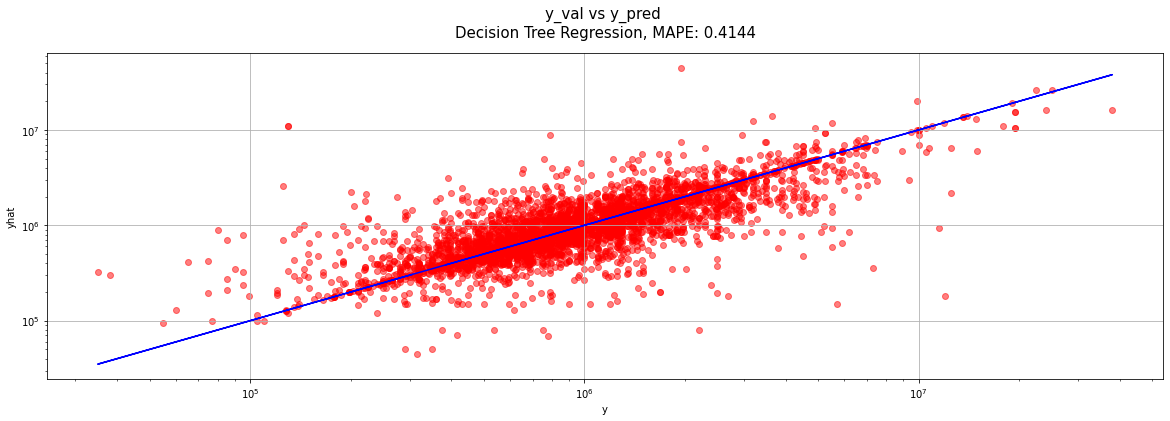

In [17]:
# make a decision Tree regression function with gridsearchCV
def decision_tree_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    max_depth=[None],
    min_samples_split=[2],
    min_samples_leaf=[1],
    cv=5,
    verbose=1,
):
    """
    This function makes a decision tree regression with gridsearchCV

    Parameters
    ----------
    X_train : numpy array
        X_train data.
    y_train : numpy array
        y_train data.
    X_val : numpy array
        X_val data.
    y_val : numpy array
        y_val data.
    max_depth : numpy array
        max_depth for the decision tree regression.
    min_samples_split : numpy array
        min_samples_split for the decision tree regression.
    min_samples_leaf : numpy array
        min_samples_leaf for the decision tree regression.
    cv : int, default=5
        Cross-validation fold.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.

    Returns
    -------
    model : object
        the best decision tree regression fitted model
    """
    # create decision tree Modell with gridsearch cv
    decision_tree = DecisionTreeRegressor()

    # create parameter grid
    param_grid = {
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        "criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
        "splitter": ["best", "random"],
        "max_features": [None, "sqrt", "log2"],
        "random_state": [42],
    }

    # create gridsearchcv model
    decision_tree_grid = GridSearchCV(
        decision_tree,
        param_grid,
        cv=cv,
        n_jobs=8,
        scoring="neg_mean_absolute_percentage_error",
        verbose=verbose,
    )

    # fit the model
    decision_tree_grid.fit(X_train, y_train)

    # print the best parameters
    print("Best parameters:", decision_tree_grid.best_params_)

    # predict the model
    y_pred_decision_tree = decision_tree_grid.predict(X_val)

    # print the mean absolute percentage error
    mape_decision_tree = mean_absolute_percentage_error(
        y_val, y_pred_decision_tree)

    # create plot y vs yhat an draw model line
    plt.figure(figsize=(20, 6))
    plt.scatter(y_val, y_pred_decision_tree, c="red", alpha=0.5)
    plt.plot(y_val, y_val, color="b")
    plt.grid()
    plt.xlabel("y")
    plt.ylabel("yhat")
    plt.title(
        "y_val vs y_pred \nDecision Tree Regression, MAPE: "
        + str(np.round(mape_decision_tree, 4)),
        fontsize=15,
        y=1.03,
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return decision_tree_grid


# call the function
decision_tree_regression = decision_tree_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    # max_depth = np.linspace(1, 10, 5, dtype=int),
    # min_samples_split = np.linspace(2, 10, 5, dtype=int),
    # min_samples_leaf = np.linspace(1, 10, 5, dtype=int),
    cv=5,
    verbose=1,
)


Der Decision Tree liefert und einen schlechteren MAPE Score als der KNN Regression. Trotzdem ist dieser interessant fuer uns, um zu schauen, ob die Feature Importance aehnlich oder gleich sind wie die von der Lasso Regression. Im naechsten Abschnitt extrahieren wir die wichtigsten Features und plotten diese in einem Barplot und schauen uns an, ob sich der MAPE Score verschlechtert.

## Untersuchung der Variable Importance Modell 6

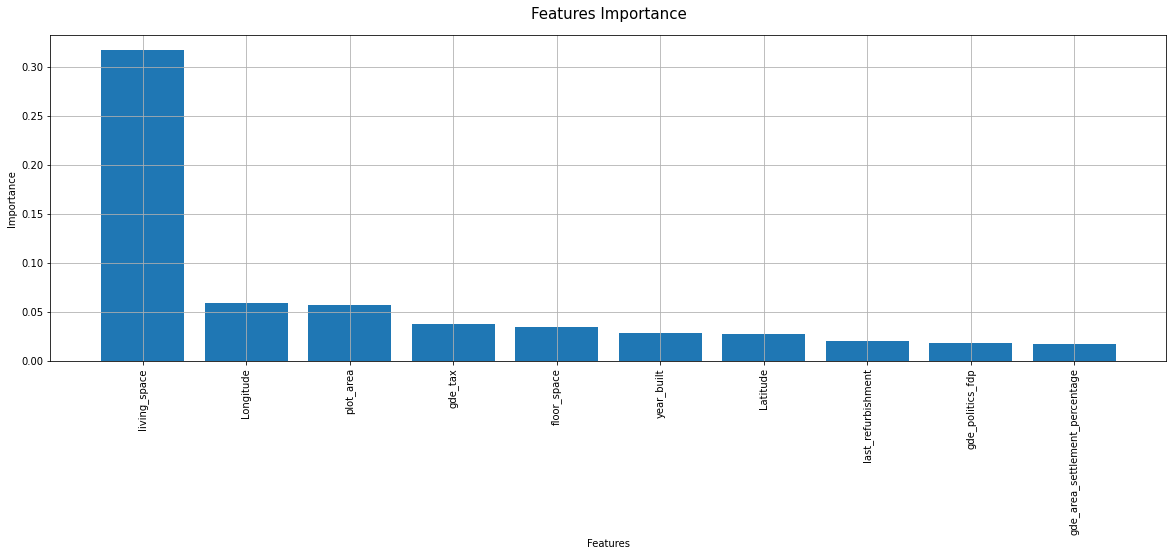

In [85]:
# create features importance list
feature_index = decision_tree_regression.best_estimator_.feature_importances_.argsort()[::-1][:10]
decision_tree_feature_importance = list(
    zip(
        decision_tree_regression.best_estimator_.feature_names_in_[feature_index],
        decision_tree_regression.best_estimator_.feature_importances_[feature_index],
    )
)

# sort feature importance list
decision_tree_feature_importance.sort(key=lambda x: x[1], reverse=True)

# extract features into a list
decision_tree_features = [x[0] for x in decision_tree_feature_importance]

# plot the features importance
plt.figure(figsize=(20, 6))
plt.bar(*zip(*decision_tree_feature_importance))
plt.grid()
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Features Importance", fontsize=15, y=1.03)
plt.show()


Im plot sind die 10 wichtigsten Feautres vom Decision Tree Modell dargestellt. Interessant ist, dass auch hier living_space die groessten Feature Importance hat, auch analog wie bei der Lasso Regression. 

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}


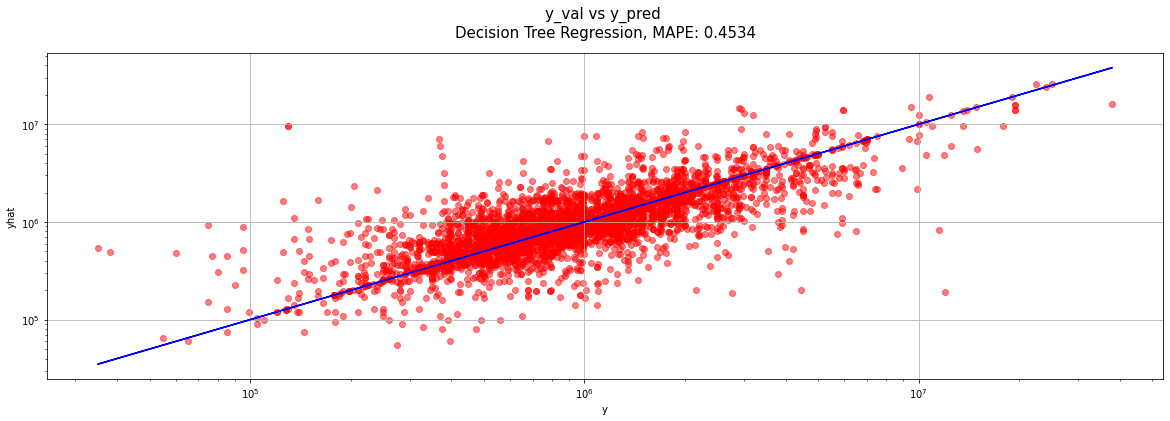

In [86]:
# call the function with best decision tree feautres
decision_tree_regression_reduced = decision_tree_regression_gridsearchCV(
    X_train[decision_tree_features],
    y_train,
    X_val[decision_tree_features],
    y_val,
    # max_depth = np.linspace(1, 10, 5, dtype=int),
    # min_samples_split = np.linspace(2, 10, 5, dtype=int),
    # min_samples_leaf = np.linspace(1, 10, 5, dtype=int),
    cv=5,
    verbose=1,
)


Wir nutzen nun die wichtigsten Features der Lasso Regression und verwenden unsere Decision Tree Regressor, und schauen uns an, wie sich der MAPE Score mit anderen Features sich veraendert. 

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'random'}


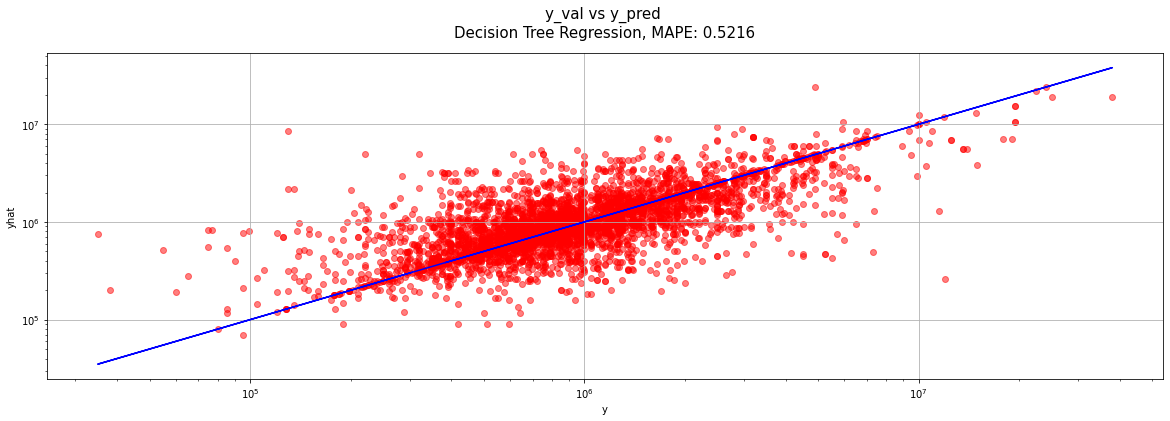

In [87]:
# call the function with best decision tree feautres
decision_tree_regression_reduced_lasso = decision_tree_regression_gridsearchCV(
    X_train[lasso_features],
    y_train,
    X_val[lasso_features],
    y_val,
    # max_depth = np.linspace(1, 10, 5, dtype=int),
    # min_samples_split = np.linspace(2, 10, 5, dtype=int),
    # min_samples_leaf = np.linspace(1, 10, 5, dtype=int),
    cv=5,
    verbose=1,
)


Durch die Auswahl der wichtigsten Features von der Lasso Regression, erhalten wir einen schlechteren MAPE Score als mit den wichtigsten Features von Decision Tree selbst.  

---
# Modell 7 - Random Forest Regression
Modell 7 ist ein Random Forest Modell. Random Forest Regression ist ein Ensemble-Modell, das auf mehreren Entscheidungsbäumen basiert. Es erstellt mehrere Entscheidungsbäume und verwendet dann die durchschnittlichen Vorhersagen aller Bäume, um die endgültige Vorhersage zu erhalten. Durch die Verwendung mehrerer Bäume wird das Risiko von Überanpassung (overfitting) reduziert und die Vorhersagen werden stabiler und zuverlässiger.

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}


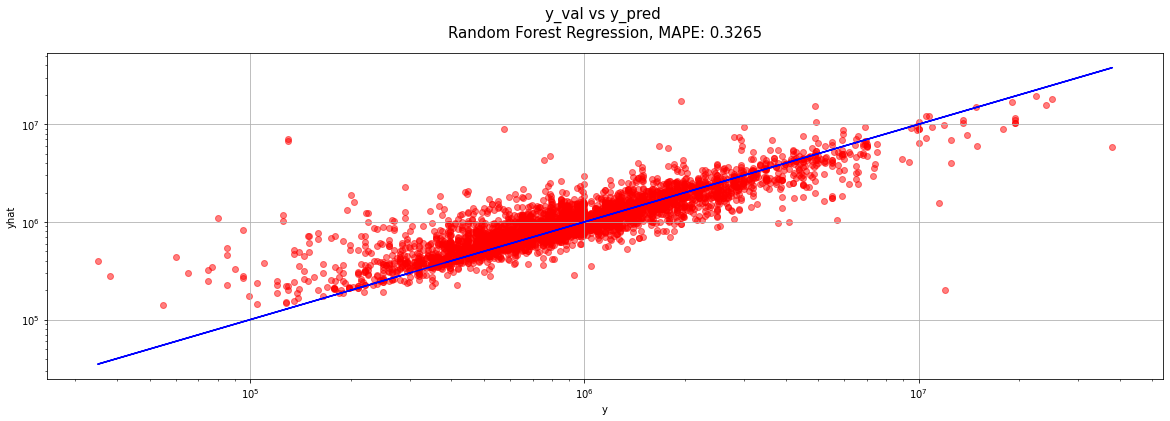

In [89]:
# make a random forest regression function with gridsearchCV
def random_forest_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    n_estimators=[100],
    max_depth=[None],
    min_samples_split=[2],
    min_samples_leaf=[1],
    cv=5,
    verbose=1,
):
    """
    This function makes a random forest regression with gridsearchCV

    Parameters
    ----------
    X_train : numpy array
        X_train data.
    y_train : numpy array
        y_train data.
    X_val : numpy array
        X_val data.
    y_val : numpy array
        y_val data.
    n_estimators : numpy array
        n_estimators for the random forest regression.
    max_depth : numpy array
        max_depth for the random forest regression.
    min_samples_split : numpy array
        min_samples_split for the random forest regression.
    min_samples_leaf : numpy array
        min_samples_leaf for the random forest regression.
    cv : int, default=5
        Cross-validation fold.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.

    Returns
    -------
    model : object
        the best random forest regression fitted model
    """
    # create random forest Modell with gridsearch cv
    random_forest = RandomForestRegressor()

    # create parameter grid
    param_grid = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        # "criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
        # "max_features": [None, "sqrt", "log2"],
        "max_features": [None],
        "random_state": [42],
    }

    # create gridsearchcv model
    random_forest_grid = GridSearchCV(
        random_forest,
        param_grid,
        cv=cv,
        n_jobs=8,
        scoring="neg_mean_absolute_percentage_error",
        verbose=verbose,
    )

    # fit the model
    random_forest_grid.fit(X_train, y_train)

    # print the best parameters
    print("Best parameters:", random_forest_grid.best_params_)

    # predict the model
    y_pred_random_forest = random_forest_grid.predict(X_val)

    # print the mean absolute percentage error
    mape_random_forest = mean_absolute_percentage_error(
        y_val, y_pred_random_forest)

    # create plot y vs yhat an draw model line
    plt.figure(figsize=(20, 6))
    plt.scatter(y_val, y_pred_random_forest, c="red", alpha=0.5)
    plt.plot(y_val, y_val, color="b")
    plt.grid()
    plt.xlabel("y")
    plt.ylabel("yhat")
    plt.title(
        "y_val vs y_pred \nRandom Forest Regression, MAPE: "
        + str(np.round(mape_random_forest, 4)),
        fontsize=15,
        y=1.03,
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return random_forest_grid


# call the function
random_forest_regression = random_forest_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    # n_estimators = np.linspace(100, 1000, 2, dtype=int),
    # max_depth = np.linspace(1, 10, 2, dtype=int),
    # min_samples_split = np.linspace(2, 10, 2, dtype=int),
    # min_samples_leaf = np.linspace(1, 10, 2, dtype=int),
    cv=4,
    verbose=1,
)


## Untersuchung der Variable Importance Modell 7

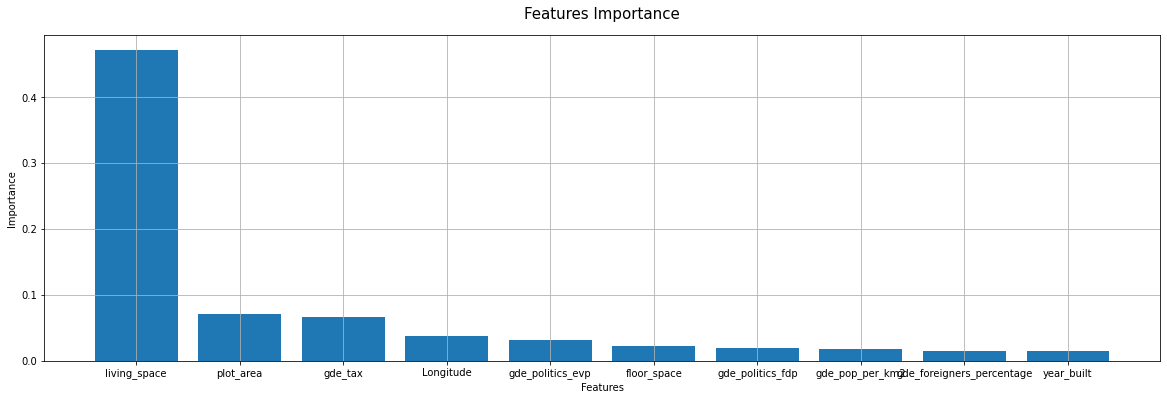

In [95]:
# feature Importance
feature_index = random_forest_regression.best_estimator_.feature_importances_.argsort()[::-1][:10]
random_forest_feautre_importance = list(
    zip(
        random_forest_regression.best_estimator_.feature_names_in_[feature_index],
        random_forest_regression.best_estimator_.feature_importances_[feature_index],
    )
)

# sort feature importance list
random_forest_feautre_importance.sort(key=lambda x: x[1], reverse=True)

# extract features into a list
random_forest_features = [x[0] for x in random_forest_feautre_importance]

# plot the features importance
plt.figure(figsize=(20, 6))
plt.bar(*zip(*random_forest_feautre_importance))
plt.grid()
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Features Importance", fontsize=15, y=1.03)
plt.show()


Analog wie beim Modell 6 sehen wir, dass living_space das wichtigste Feature im Modell ist, um unseren Immobilienpreis vorhersagen zu koennen. Wir erstellen im naechsten Schritt das gleiche Modell, einfach nur mit den wichtigsten Features. Erwartungsgemaess versclechtert sich der MAPE einwenig.

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}


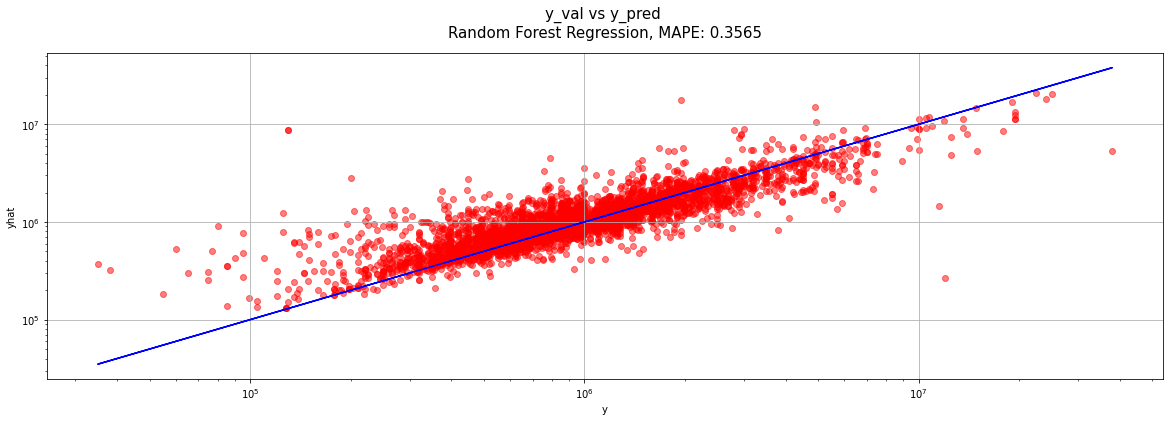

In [96]:
# call the function with random forest features
random_forest_regression_reduced = random_forest_regression_gridsearchCV(
    X_train[random_forest_features],
    y_train,
    X_val[random_forest_features],
    y_val,
    # n_estimators = np.linspace(100, 1000, 2, dtype=int),
    # max_depth = np.linspace(1, 10, 2, dtype=int),
    # min_samples_split = np.linspace(2, 10, 2, dtype=int),
    # min_samples_leaf = np.linspace(1, 10, 2, dtype=int),
    cv=4,
    verbose=1,
)


Interessenshalber nehmen wir nun die wichtigsten Features aus dem Modell decision Tree und Lasso Regression.

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}


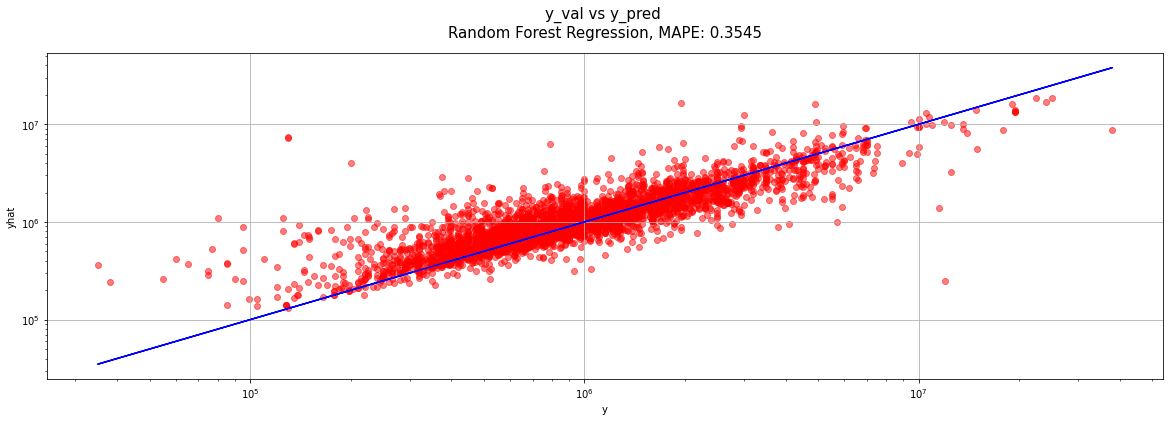

In [97]:
# call the function with decision tree features
random_forest_regression_reduced_tree = random_forest_regression_gridsearchCV(
    X_train[decision_tree_features],
    y_train,
    X_val[decision_tree_features],
    y_val,
    # n_estimators = np.linspace(100, 1000, 2, dtype=int),
    # max_depth = np.linspace(1, 10, 2, dtype=int),
    # min_samples_split = np.linspace(2, 10, 2, dtype=int),
    # min_samples_leaf = np.linspace(1, 10, 2, dtype=int),
    cv=4,
    verbose=1,
)


Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}


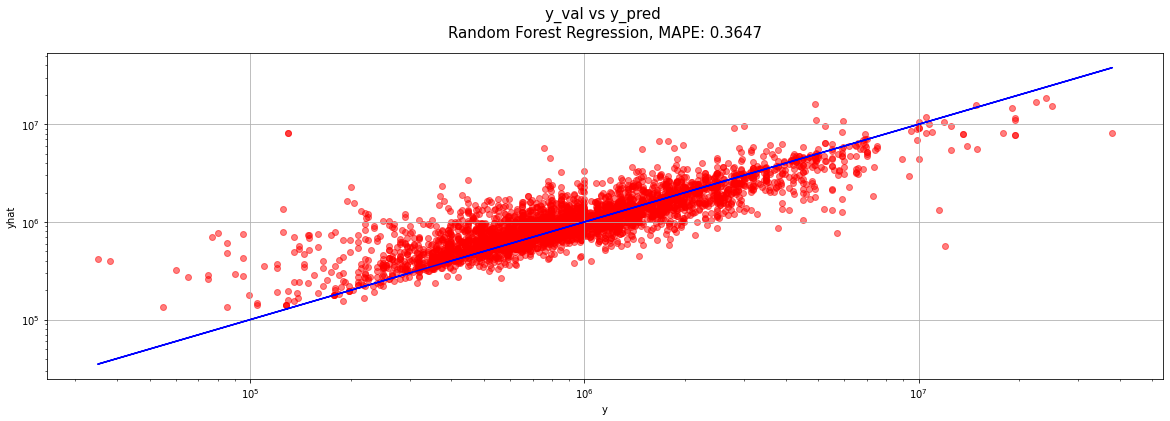

In [98]:
# call the function with lasso features
random_forest_regression_reduced_lasso = random_forest_regression_gridsearchCV(
    X_train[lasso_features],
    y_train,
    X_val[lasso_features],
    y_val,
    # n_estimators = np.linspace(100, 1000, 2, dtype=int),
    # max_depth = np.linspace(1, 10, 2, dtype=int),
    # min_samples_split = np.linspace(2, 10, 2, dtype=int),
    # min_samples_leaf = np.linspace(1, 10, 2, dtype=int),
    cv=4,
    verbose=1,
)


Wie wir durch unsere Modelle und Plots zeigen konnte, koennen wir durchaus unsere Modelle vereinfachen indem wir nur die wichtigsten Features aus unserem Datensatz nehmen und unser Modell entsprechen trainieren und validieren. 

Ein Interessante Beobachtung ist, dass alle wichtigen Features von Lasso, Decision Tree und Random Forest Tree zu fast gleichen MAPE Score fuehrt. Durch die Selektion der wichtigsten Features, koennen wir unsere Modelle vereinfachen und die Performance verbessern.

---
# Modell 8 - Gradient Boosting Regression
Modell 8 ist ein Gradient Boosting Modell. Gradient Boosting Regression ist ein weiteres Ensemble-Modell, das auf Gradient Boosting-Algorithmen basiert. Es erstellt mehrere schwache Modelle und fügt sie dann schrittweise zu einem stärkeren Modell zusammen, indem es auf Fehler des vorherigen Modells fokussiert. GBR ist ein sehr mächtiges Modell, aber es kann leicht zu überanpassen(overfitting) führen, falls nicht sorgfältig reguliert wird.

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}


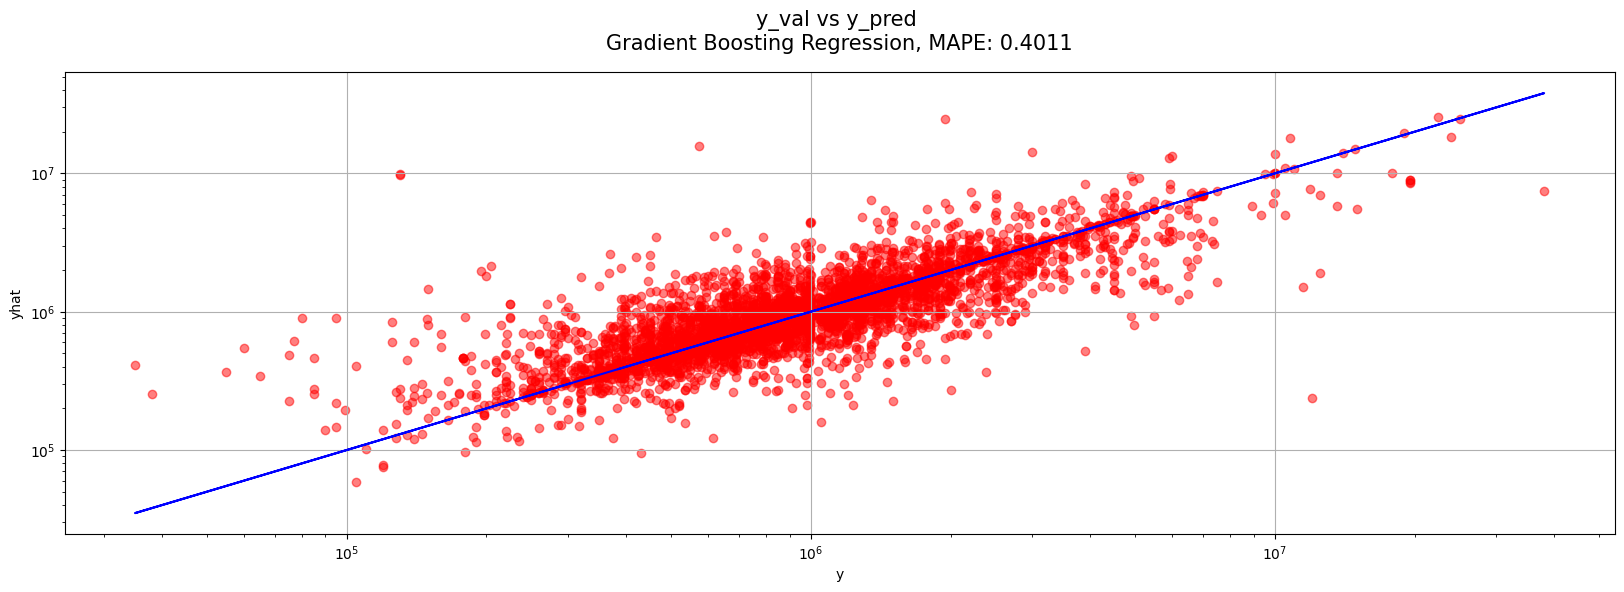

In [26]:
# make a gradient boosting regression function with gridsearchCV
def gradient_boosting_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    learning_rate=[0.1],
    n_estimators=[100],
    max_depth=[None],
    min_samples_split=[2],
    min_samples_leaf=[1],
    cv=5,
    verbose=1,
):
    """
    This function makes a gradient boosting regression with gridsearchCV

    Parameters
    ----------
    X_train : numpy array
        X_train data.
    y_train : numpy array
        y_train data.
    X_val : numpy array
        X_val data.
    y_val : numpy array
        y_val data.
    learning_rate : numpy array
        learning_rate for the gradient boosting regression.
    n_estimators : numpy array
        n_estimators for the gradient boosting regression.
    max_depth : numpy array
        max_depth for the gradient boosting regression.
    min_samples_split : numpy array
        min_samples_split for the gradient boosting regression.
    min_samples_leaf : numpy array
        min_samples_leaf for the gradient boosting regression.
    cv : int, default=5
        Cross-validation fold.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.

    Returns
    -------
    model : object
        the best gradient boosting regression fitted model
    """
    # create gradient boosting Modell with gridsearch cv
    gradient_boosting = GradientBoostingRegressor()

    # create parameter grid
    param_grid = {  # "loss": ["squared_error", "absolute_error", "huber", "quantile"],
        "learning_rate": learning_rate,
        "n_estimators": n_estimators,
        # "criterion": ["friedman_mse", "mse", "mae"],
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
        "min_samples_leaf": min_samples_leaf,
        # "max_features": ["auto", "sqrt", "log2"],
        "random_state": [42],
        # alpha for quantile and huber
        # "alpha": np.linspace(0, 0.9, 4)
    }

    # create gridsearchcv model
    gradient_boosting_grid = GridSearchCV(
        gradient_boosting,
        param_grid,
        cv=cv,
        n_jobs=8,
        scoring="neg_mean_absolute_percentage_error",
        verbose=verbose,
    )

    # fit the model
    gradient_boosting_grid.fit(X_train, y_train)

    # print the best parameters
    print("Best parameters:", gradient_boosting_grid.best_params_)

    # predict the model
    y_pred_gradient_boosting = gradient_boosting_grid.predict(X_val)

    # print the mean absolute percentage error
    mape_gradient_boosting = mean_absolute_percentage_error(
        y_val, y_pred_gradient_boosting
    )

    # create plot y vs yhat an draw model line
    plt.figure(figsize=(20, 6))
    plt.scatter(y_val, y_pred_gradient_boosting, c="red", alpha=0.5)
    plt.plot(y_val, y_val, color="b")
    plt.grid()
    plt.xlabel("y")
    plt.ylabel("yhat")
    plt.title(
        "y_val vs y_pred \nGradient Boosting Regression, MAPE: "
        + str(np.round(mape_gradient_boosting, 4)),
        fontsize=15,
        y=1.03,
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return gradient_boosting_grid


# call the function
gradient_boosting_regression = gradient_boosting_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    # learning_rate = np.linspace(0.1, 1, 2, dtype=int),
    # n_estimators = np.linspace(100, 1000, 2, dtype=int),
    # max_depth = np.linspace(1, 10, 2, dtype=int),
    # min_samples_split = np.linspace(2, 10, 2, dtype=int),
    # min_samples_leaf = np.linspace(1, 10, 2, dtype=int),
    cv=5,
    verbose=1,
)


Der Gradient Boosting Regression ist schlechter als unsere Modelle von Random Forest und Decision Tree. 

---
# Modell 9 - XGBoost Regression
Modell 9 ist ein XGBoost Modell. XGBoost Regression ist ein weiteres Ensemble-Modell, das auf Gradient Boosting-Algorithmen basiert, es ist allerdings speziell für die Beschleunigung von Gradient Boosting und für die Handhabung von großen Datensätzen optimiert. Es bietet mehrere fortgeschrittene Funktionen wie automatisches Ressourcen-Management und reguläre Optimierungen.

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best parameters: {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 15, 'random_state': 42}


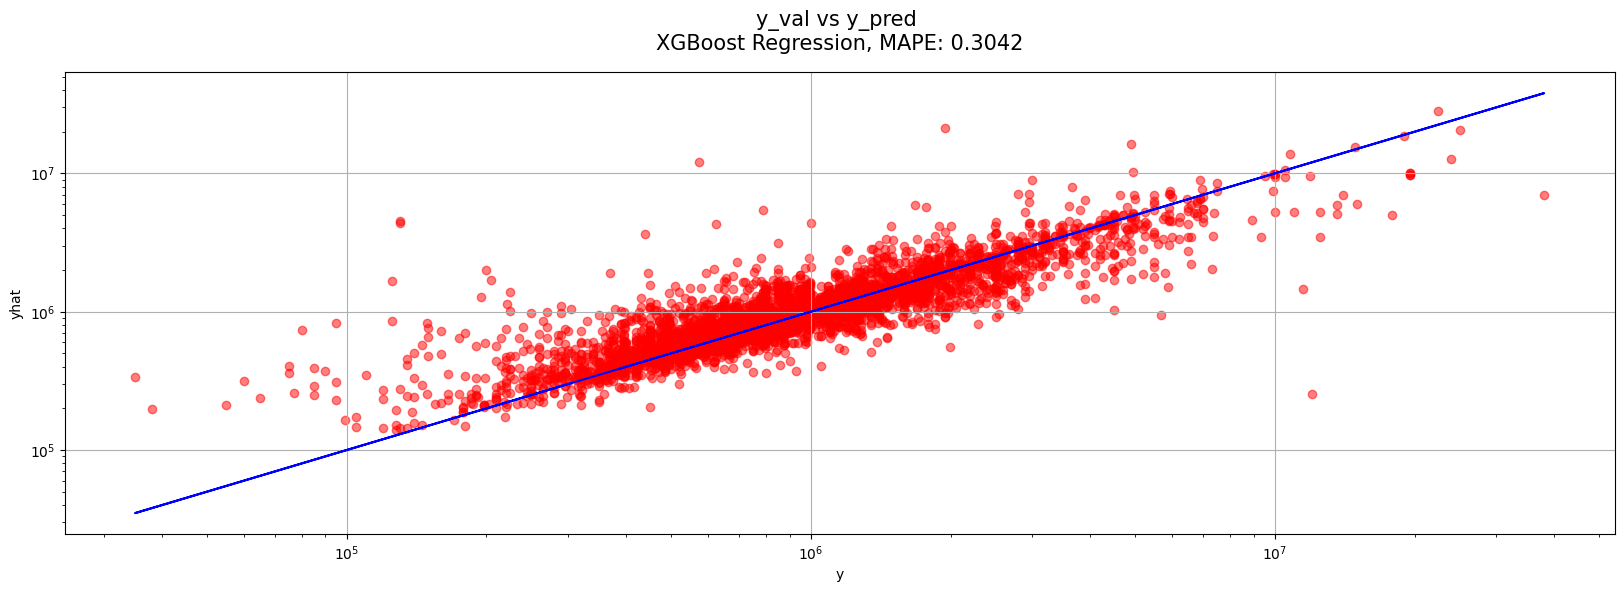

In [27]:
# make a xgboost regression function with gridsearchCV
def xgboost_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    learning_rate=[0.1],
    max_depth=[6],
    cv=5,
    verbose=1,
):
    """
    This function makes a xgboost regression with gridsearchCV

    Parameters
    ----------
    X_train : numpy array
        X_train data.
    y_train : numpy array
        y_train data.
    X_val : numpy array
        X_val data.
    y_val : numpy array
        y_val data.
    learning_rate : numpy array
        learning_rate for the xgboost regression.
    cv : int, default=5
        Cross-validation fold.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.

    Returns
    -------
    model : object
        the best xgboost regression fitted model
    """
    # create xgboost Modell with gridsearch cv
    xgboost = XGBRegressor()

    # create parameter grid
    param_grid = {
        "learning_rate": learning_rate,
        "random_state": [42],
        "booster": ["gbtree"],
        "max_depth": max_depth,
    }

    # create gridsearchcv model
    xgboost_grid = GridSearchCV(
        xgboost,
        param_grid,
        cv=cv,
        n_jobs=8,
        scoring="neg_mean_absolute_percentage_error",
        verbose=verbose,
    )

    # fit the model
    xgboost_grid.fit(X_train, y_train)

    # print the best parameters
    print("Best parameters:", xgboost_grid.best_params_)
    # predict the model
    y_pred_xgboost = xgboost_grid.predict(X_val)

    # print the mean absolute percentage error
    mape_xgboost = mean_absolute_percentage_error(y_val, y_pred_xgboost)

    # create plot y vs yhat an draw model line
    plt.figure(figsize=(20, 6))
    plt.scatter(y_val, y_pred_xgboost, c="red", alpha=0.5)
    plt.plot(y_val, y_val, color="b")
    plt.grid()
    plt.xlabel("y")
    plt.ylabel("yhat")
    plt.title(
        "y_val vs y_pred \nXGBoost Regression, MAPE: " +
        str(np.round(mape_xgboost, 4)),
        fontsize=15,
        y=1.03,
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return xgboost_grid


# call the function
xgboost_regression = xgboost_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    cv=4,
    learning_rate=[0.1],
    max_depth=[15],
    verbose=1,
)


XGboost liefert uns einen guten MAPE Score. 

---
# Modell 10 - Histgradientboosting Regression (log transformation)
Modell 10 ist ein Histgradientboosting Modell. HistGradientBoosting Regression ist eine spezielle Art der Gradient Boosting Regression, die von Gradient Boosting-Algorithmen für große Datensätze und hohe Dimensionen optimiert ist. Es nutzt eine besondere Technik namens histograms, welche es ermöglicht effizient mit numerischen Features umzugehen und so die Rechenzeit zu reduzieren.

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best parameters: {'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 18, 'max_leaf_nodes': None, 'random_state': 42}


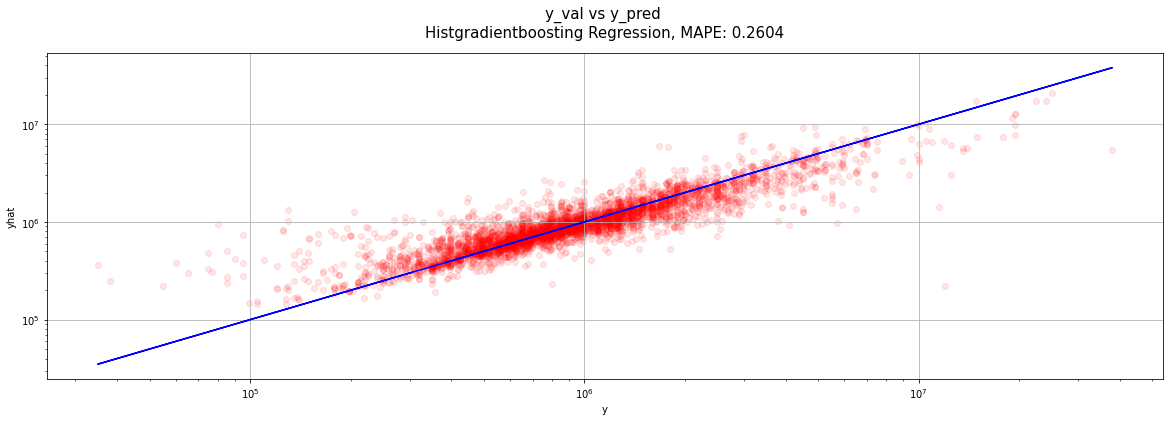

In [19]:
# make a histgradientboosting regression function with gridsearchCV
def histgradientboosting_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    learning_rate=[0.1],
    max_depth=[6],
    cv=5,
    verbose=1,
):
    """
    This function makes a histgradientboosting regression with gridsearchCV

    Parameters
    ----------
    X_train : numpy array
        X_train data.
    y_train : numpy array
        y_train data.
    X_val : numpy array
        X_val data.
    y_val : numpy array
        y_val data.
    learning_rate : numpy array
        learning_rate for the histgradientboosting regression.
    cv : int, default=5
        Cross-validation fold.
    verbose : int, default=1
        Controls the verbosity: the higher, the more messages.

    Returns
    -------
    model : object
        the best histgradientboosting regression fitted model
    """
    # create histgradientboosting Modell with gridsearch cv
    histgradientboosting = HistGradientBoostingRegressor()

    # create parameter grid
    param_grid = {
        "loss": ["absolute_error"],
        "learning_rate": learning_rate,
        "random_state": [42],
        "max_depth": max_depth,
        "max_leaf_nodes": [None],
        # "l2_regularization": [0.01, 0.1, 1],
    }

    # create gridsearchcv model
    histgradientboosting_grid = GridSearchCV(
        histgradientboosting,
        param_grid,
        cv=cv,
        n_jobs=8,
        scoring="neg_mean_absolute_percentage_error",
        verbose=verbose,
    )

    # fit the model
    histgradientboosting_grid.fit(X_train, np.log(y_train))

    # print the best parameters
    print("Best parameters:", histgradientboosting_grid.best_params_)
    # predict the model
    y_pred_histgradientboosting = histgradientboosting_grid.predict(X_val)
    y_pred_histgradientboosting = np.exp(y_pred_histgradientboosting)

    # print the mean absolute percentage error
    mape_histgradientboosting = mean_absolute_percentage_error(
        y_val, y_pred_histgradientboosting
    )

    # create plot y vs yhat an draw model line
    plt.figure(figsize=(20, 6))
    plt.scatter(y_val, y_pred_histgradientboosting, c="red", alpha=0.1)
    plt.plot(y_val, y_val, color="b")
    plt.grid()
    plt.xlabel("y")
    plt.ylabel("yhat")
    plt.title(
        "y_val vs y_pred \nHistgradientboosting Regression, MAPE: "
        + str(np.round(mape_histgradientboosting, 4)),
        fontsize=15,
        y=1.03,
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

    return histgradientboosting_grid


# call the function
histgradientboosting_regression = histgradientboosting_regression_gridsearchCV(
    X_train,
    y_train,
    X_val,
    y_val,
    cv=4,
    learning_rate=[0.1],
    max_depth=[18],
    verbose=1,
)


Durch die log Transformation unserer Zielvariabel Price, konnten wir einen besseren Score erreichen. 

---
# Modell 11 - Histgradientboosting Regression (log transformation) with NA
Modell 11 ist ein Histgradientboosting Modell, welches mit NA Werten umgehen kann. HistGradientBoostingRegression with NA ist eine weitere spezielle Art der Gradient Boosting Regression, es erweitert die HistGradientBoosting Regression um die Möglichkeit fehlende Werte (NA) in den Daten zu handhaben. Es nutzt dazu eine spezielle Technik der Imputation fehlender Werte, welche es ermöglicht das Modell zu trainieren auch wenn nicht alle Daten vollständig sind.

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best parameters: {'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 25, 'max_leaf_nodes': None, 'random_state': 42}


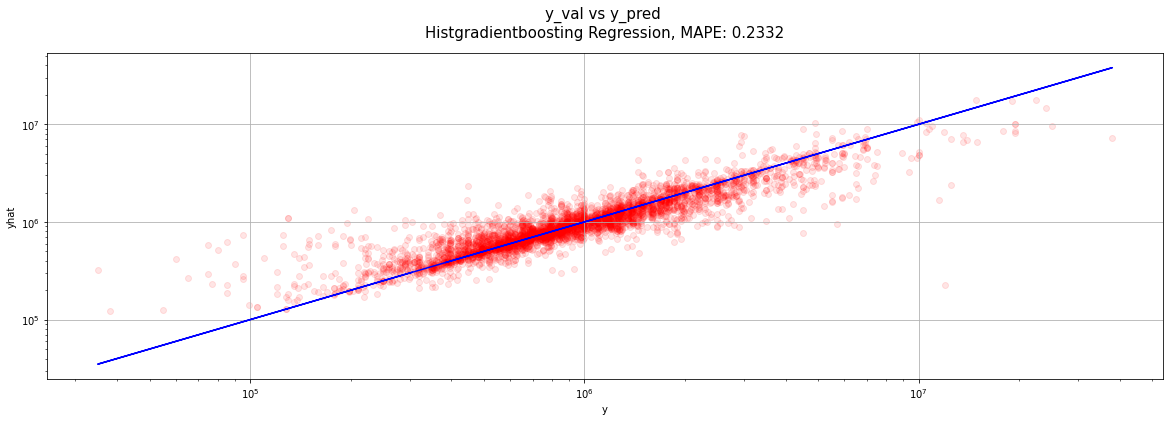

In [20]:
histgradientboosting_regression_with_na = histgradientboosting_regression_gridsearchCV(
    X_train_with_na,
    y_train,
    X_val_with_na,
    y_val,
    cv=4,
    learning_rate=[0.1],
    max_depth=[25],
    verbose=1,
)


---
# Vergleiche der Modelle
Hier werden die Modelle miteinander verglichen und tabellerisch sowie visualisiert dargestellt.
Dabei dient das Modell 1 - Multiple Linear Model, als Benchmark.

,Model,MAPE
9,HistGradientBoosting Regression with NA,0.233239
8,HistGradientBoosting Regression,0.260161
7,XGBoost Regression,0.304185
6,RandomForest Regression,0.327054
4,KNeighbors Regression,0.382445
5,DecisionTree Regression,0.418579
2,Ridge Regression,0.500405
1,Lasso Regression,0.505737
3,ElasticNet Regression,0.505737
0,Linear Regression,3187350940.207475


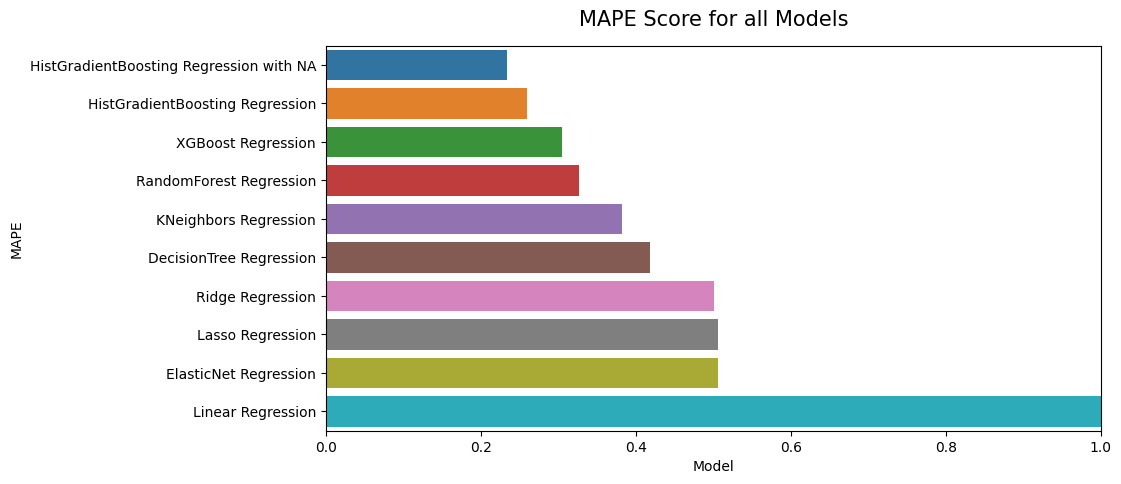

In [30]:
# create a dictionary for all models and their MAPE score

models = {
    "Multiple Linear Regression": linear_regression,
    "Lasso Regression": lasso_regression,
    "Ridge Regression": ridge_regression,
    "ElasticNet Regression": elastic_net_regression,
    "KNeighbors Regression": knn_regression,
    "DecisionTree Regression": decision_tree_regression,
    "RandomForest Regression": random_forest_regression,
    "XGBoost Regression": xgboost_regression,
    "HistGradientBoosting Regression": histgradientboosting_regression,
    "HistGradientBoosting Regression with NA": histgradientboosting_regression_with_na,
}

# create a dataframe for all models and their MAPE score
df_models = pd.DataFrame(columns=["Model", "MAPE"], index=range(len(models)))

# fill the dataframe with the models and their MAPE score
for i, model in enumerate(models):
    df_models.loc[i, "Model"] = model
    df_models.loc[i, "MAPE"] = mean_absolute_percentage_error(
        y_val, models[model].predict(X_val)
    )

df_models.loc[8, "MAPE"] = mean_absolute_percentage_error(
    y_val, np.exp(models["HistGradientBoosting Regression"].predict(X_val))
)

df_models.loc[9, "MAPE"] = mean_absolute_percentage_error(
    y_val,
    np.exp(models["HistGradientBoosting Regression with NA"].predict(
        X_val_with_na)),
)

# sort dataframe by MAPE score
df_models = df_models.sort_values(by="MAPE", ascending=True)

# display dataframe
display(df_models)

# create a barplot for all models and their MAPE score on top of the bars
plt.figure(figsize=(10, 5))
sns.barplot(y="Model", x="MAPE", data=df_models)
plt.title("MAPE Score for all Models", fontsize=15, y=1.03)
plt.xlabel("Model")
plt.ylabel("MAPE")
plt.xlim(0, 1)
plt.show()


Wir erkenne im Barplot deutlich, das alle Modelle besser sind als das multiple lineare Regression. Schon unser zweites Modell, das Lasso Modell schlaegt unser Benchmark um das vielfache. Das beste Modell, welches wir fuer unsere Preisvorhersage nutzen ist das HistGradientBoosting Regression with NA. Dicht gefolgt wird diese durch das gleiche Modell, jedoch ohne mit der Eigenschaft, mit NA Werten umgehen zu koennen. Auf dem dritten Platz befindet sich XGBoost Modell. Alle drei Modelle liefern uns einen sehr guten MAPE Score bei unseren Validierungsdatensatze. Auf Kaggle haben wir unterschiedliche Submission gemacht und auch hier, analog zum Testdatensatz, liefert das HistGradientBoosting Regression with NA die besten Resultate in Bezug auf den MAPE Score.

---
# Untersuchung der "Variable Importance" 
Wir haben vorzugsweise die Variabel Importance die Modelle Lasso, Decision Tree und Random Forest Tree Regression untersucht und konnten feststellen, dass wir unsere Modelle deutlich vereinfachen koennen durch wenige wichtige Feature, nehmen aber jedoch bewusst in Kauf, dass unser MAPE Score dann verschlechtert wird. 


---

# Predict Kaggle Data


In [32]:
predictions = pd.DataFrame(
    {
        "Id": X_kaggle_with_na.index,
        "Expected": np.exp(
            histgradientboosting_regression_with_na.predict(X_kaggle_with_na)
        ),
    }
)

predictions.to_csv("predictions.csv", index=False)


---
# Fazit
Wir konnten in diesem Notebook unsere Kenntnisse mit verschiedenen Sklearn Modellen verbessern und erweitern. Es hat uns Spass gemacht, stueck fuer stueck den MAPE Score zu optimieren und unterschiedliche Regression Modelle anzuwenden und den MAPE von jedem Modell zu vergleichen. 

Unser Letztes Modell der HistGradientBoostingRegressor with NA liefert und den besten MAPE Score. Wir haben uns entschieden dieses Modell zu verwenden, da es uns die Moeglichkeit gibt, mit NA Werten umgehen zu koennen. Nach aktuellem Stand (10.01.2023), stehen wir auch im Leaderboard auf Kaggle auf den ersten Platz mit unserem Modell mit den Trainingsdatensatz. 
